<font size = '7' color = 'brown'> <div padding-down = 0, align = "center"> <strong> Neural Networks and Intelligent Systems </strong> </div> </font>
<font size = '6' color = 'brown'> <div align = "center"> <strong> Part 2: Kaggle dataset </strong> </div> </font>
<br>

<font size = '6' color = 'orange'> <div align = "center"> <strong> Εισαγωγή του dataset και Επισκόπηση </strong> </div> </font>

Σε αυτό το κομμάτι της εργασίας θα χρησιμοποιήσουμε το dataset Sloan Digital Sky Survey DR16. Το συγκεκριμένο dataset περιέχει φωτομετρικά και φασματικά δεδομένα που χρησιμοποιούνται για να δημιουργηθούν τρισδιάστατα μοντέλα του διστήματος. Τα δείγματα ταξινομούνται σε τρεις διαφορετικές κλάσεις ('GALAXY', 'STAR, 'QSO'), άρα έχουμε multi-class dataset format. Οπότε εισάγουμε το dataset στο workspace μας και προβαίνουμε στην μελέτη του.


In [1]:
# Download or update necessary packeges

#!pip install sklearn
!pip install ray
!pip install ray[tune] 
!pip install scikit-learn
#!pip install numpy
!pip install tune-sklearn

#ignore non-important warnings
import warnings 
warnings.filterwarnings('ignore')

# LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib.pyplot as plt # to draw plots
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn import svm
import time
from sklearn.preprocessing import StandardScaler # φέρνουμε τον StandarScaler ως transformer που έχει .transform kai ΄όχι ως scale()
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from tune_sklearn import TuneGridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

In [2]:
#df = pd.read_csv("Skyserver_12_30_2019-4_49_58-PM.csv") # for local execution from downloaded csv
df = pd.read_csv("/kaggle/input/sloan-digital-sky-survey-dr16/Skyserver_12_30_2019 4_49_58 PM.csv") #to run it from kaggle

print("The number of samples is:", df.shape[0], "\nThe number of features is:", df.shape[1])
print("\nSome information regarding the dataframe:\n")

df.info()
print("")
df.head(5) #print first n (default 5) rows

The number of samples is: 100000 
The number of features is: 18

Some information regarding the dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      100000 non-null  int64  
 1   ra         100000 non-null  float64
 2   dec        100000 non-null  float64
 3   u          100000 non-null  float64
 4   g          100000 non-null  float64
 5   r          100000 non-null  float64
 6   i          100000 non-null  float64
 7   z          100000 non-null  float64
 8   run        100000 non-null  int64  
 9   rerun      100000 non-null  int64  
 10  camcol     100000 non-null  int64  
 11  field      100000 non-null  int64  
 12  specobjid  100000 non-null  uint64 
 13  class      100000 non-null  object 
 14  redshift   100000 non-null  float64
 15  plate      100000 non-null  int64  
 16  mjd        100000 non-null  int64  
 17

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832
1,1237673706652430000,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220,9333948945297330000,STAR,-0.000093,8290,57364,868
2,1237671126974140000,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13,3221211255238850000,STAR,0.000165,2861,54583,42
3,1237665441518260000,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,4649,301,3,121,2254061292459420000,GALAXY,0.058155,2002,53471,35
4,1237665441522840000,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,4649,301,3,191,2390305906828010000,GALAXY,0.072210,2123,53793,74


Επομένως συμπεραίνουμε ότι έχουμε 100000 δείγματα, ενώ τα χαρακτηριστηκά για κάθε δείγμα είναι 18, από τα οποία το ένα αποτελεί τη στήλη "class" που αντιστοιχίζει κάθε δείγμα σε μία συγεκριμένη κλάση αντικειμένων. <br>
Πιο αναλυτικά, τα χαρακτηριστικά είναι τα εξής:
* objid = Object Identifier
* ra = J2000 Right Ascension (r-band)
* dec = J2000 Declination (r-band)
* u = better of deV/Exp magnitude fit (u-band)
* g = better of deV/Exp magnitude fit (g-band)
* r = better of deV/Exp magnitude fit (r-band)
* i = better of deV/Exp magnitude fit (i-band)
* z = better of deV/Exp magnitude fit (z-band)
* run = Run Number
* rerun = Rerun Number
* camcol = Camera column
* field = Field number
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object)
* redshift = Final Redshift
* plate = plate number
* mjd = MJD of observation
* fiberid = fiberID
<br>

Όπως φαίνεται, τα χαρακτηριστικά μας είναι όλα ποσοτικά, και δεν συναντόνται διατεταγμένα χαρακτηριστικά. <br>

In [3]:
df['class'].value_counts() #return a Series containing counts of unique values.

GALAXY    51323
STAR      38096
QSO       10581
Name: class, dtype: int64

Βλέπουμε ότι έχουμε 3 κλάσεις με ετικέτες 'GALAXY', 'STAR', 'QSO' και βρίσκονται στην 14η κολόνα. Τα ποσοστά δειγμάτων τους επί του συνόλου των δεδομένων είναι:
* GALAXY: 51.323%
* STAR: 38.096%
* QSO: 10.581%

Άρα, το dataset μας δεν είναι ισορροπημένο αφού η κλάση 'GALAXY" είναι περισσότερο από 1.5 φορά πιο συχνή από την κλάση 'QSO', γεγονός που μπορεί να δυσκολέψει την σωστή πρόβλεψη των κβάζαρ (QSO) λόγω των εξαιρετικά λιγότερων δειγμάτων.

In [4]:
print('Number of NaN values for each feature:\n', df.isnull().sum()) 

Number of NaN values for each feature:
 objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64


Παρατηρούμε ότι δεν υπάρχουν απουσιάζουσες τιμές. Τέλος, τυπώνουμε ορισμένα στατιστικά για τα δεδομένα του dataframe μας.

In [5]:
df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237663e+18,177.512888,25.052056,18.637915,17.407128,16.881676,16.625534,16.467087,3978.727640,301.0,3.274010,187.243080,2.913905e+18,0.170621,2587.984270,53913.908690,341.699080
std,7.264931e+12,78.039070,20.567259,0.832284,0.985921,1.133337,1.209532,1.281788,1691.498597,0.0,1.621208,141.037298,2.488872e+18,0.437571,2210.547391,1547.244489,217.068614
min,1.237646e+18,0.013061,-19.495456,10.611810,9.668339,9.005167,8.848403,8.947795,109.000000,301.0,1.000000,11.000000,2.994897e+17,-0.004136,266.000000,51608.000000,1.000000
25%,1.237658e+18,136.356526,6.770380,18.212902,16.852982,16.196607,15.865275,15.619960,2826.000000,301.0,2.000000,85.000000,1.335426e+18,0.000001,1186.000000,52733.000000,160.000000
50%,1.237662e+18,180.411688,23.918611,18.873250,17.515860,16.890640,16.599885,16.428385,3900.000000,301.0,3.000000,153.000000,2.354330e+18,0.045997,2091.000000,53726.000000,328.000000
75%,1.237667e+18,224.369107,40.344539,19.273302,18.056060,17.585750,17.344912,17.234625,5061.000000,301.0,5.000000,249.000000,3.276384e+18,0.095429,2910.000000,54585.000000,502.000000
max,1.237681e+18,359.999615,84.490494,19.599950,19.996050,31.990100,32.141470,29.383740,8162.000000,301.0,6.000000,982.000000,1.317645e+19,7.011245,11703.000000,58543.000000,1000.000000


<font size = '6' color = 'orange'> <div align = "center"> <strong> Μετρικές </strong> </div> </font>

Οι μετρικές με τις οποίες θα δουλέψουμε είναι το Accuracy και το F1. Αφ'ενός το Accuracy θα μας δείξει πόσο καλοί είναι οι ταξινομητές μας (πόσα δηλαδή δείγματα ταξινόμησαν στην σωστή κλάση). Αφ΄ εταίρου, το F1 μας πληροφορεί ταυτόχρονα και για το Precison (το ποσοστό των δειγμάτων που κατατάχτηκαν σε μία κλάση και πράγματι ανήκουν σε αυτήν) και το Recall (το ποσοστό των δειγμάτων που κατατάχτηκαν σωστά σε μία κλάση σε σύγκριση με το συνολικό πλήθος των δειγμάτων που θα έπρεπε να καταταχτούν σε αυτήν), και μάλιστα ενδείκνυται για μη-ισορροπημένα datasets, όπως το δικό μας πριν την προεπεξεργασία. 

<font size = '6' color = 'orange'> <div align = "center"> <strong> Train-Test split και σχήμα CV </strong> </div> </font>

Cross validation θα πραγματοποίησουμε μέσω της βιβλιοθηκης Ray και συγκεκριμένα θα χρησιμοποίησουμε την συνάρτηση TuneGridSearchCV(), καθώς είναι αρκετά γρηγορότερη και παράλληλα καταναλώνει αρκετά λιγότερους πόρους μνήμης σε σχέση με άλλες μεθόδους βελτιστοπίησης, κάτι που θα φανεί πολύ χρήσιμο στην περίπτωσή μας που έχουμε μεγάλο dataset. 

Το ποσοστό train-split το οποίο επιλέξαμε είναι το 70-30, καθώς μας δίνει ένα αρκετά μεγάλο train set και ταυτόχρονο ένα ικανοποιητικό μέγεθος του test set. 
Πριν κάνουμε το split, χωρίσαμε σε x και y άξονα τα features (x άξονας) και το label (y άξονας), έτσι ώστε να λειτουργήσουν σωστά οι ταξινομητές μας. 

In [6]:
y = df['class']
x = df.drop(['class'], axis = 1)

# Split our data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

<font size = '6' color = 'orange'> <div align = "center"> <strong> Επίδοση Out-of-the-Box </strong> </div> </font>
Αρχικά, χρειάστηκε να μετατρέψουμε τα κατηγορικά δεδομένα μας σε αριθμητικά, το οποίο το υλοποιήσαμε με τον παρακάτω τρόπο. 

In [7]:
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
final_y_train = []
final_y_test = []

for cl in y_train:
    final_y_train.append(labels[cl])
for cl in y_test:
    final_y_test.append(labels[cl])

# **MLP**


Ακολουθεί η εκπαίδευση του εκτιμητή χρησιμοποιόντας τον ταξινομητή Multi-Layer Perceptron (MLP): 

In [8]:
clf_ootb = MLPClassifier()

start = time.time()
clf_ootb.fit(x_train, final_y_train)
end = time.time()

mlp_ootb_time = end - start

clf_preds_ootb = clf_ootb.predict(x_test)
cr_mlp_ootb = classification_report(final_y_test, clf_preds_ootb)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_mlp_ootb)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, clf_preds_ootb))
print('Fit time: ', mlp_ootb_time)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.58      0.83      0.68     11526
           2       0.75      0.67      0.71     15306
           3       0.00      0.00      0.00      3168

    accuracy                           0.66     30000
   macro avg       0.44      0.50      0.46     30000
weighted avg       0.61      0.66      0.62     30000

Confusion Matrix: 
 [[ 9566  1960     0]
 [ 5124 10182     0]
 [ 1755  1413     0]]
Fit time:  10.571527004241943


Όπως βλέπουμε η επίδοση του ταξινομητή είναι μέτρια προς κακή, κάτι το οποίο το περιμέναμε, καθώς ο ταξινομητής MLP δεν λειτουργεί καλά χωρις προεπεξεργασία και βελτίωση των υπερπαραμέτρων του. Μία ακόμη ένδειξη της κακης επίδοσης του ταξινομητή είναι πως σε μία από τις κλάσεις όλες οι μετρικές επίδοσής μας έχουν μηδενική τιμή, κάποιες από τις φορές που τον τρέχουμε.  

# **SVM**

Ακολουθεί η εκπαίδευση του εκτιμητή χρησιμοποιώντας τον ταξινομητή Support Vector Machines (SVM). Όπως και προηγουμένως, θεωρείται καλή πρακτική να μετατρέψουμε τις ετικέτες των κατηγοριών σε ακέραιους αριθμούς (αν και στην περίπτωση του svc γίνεται εσωτερικά η μετατροπή).

In [9]:
svc_ootb = svm.SVC()

start = time.time()
svc_ootb.fit(x_train, final_y_train)
end = time.time()

svc_ootb_time = end - start

svc_preds_ootb = svc_ootb.predict(x_test)
cr_svc_ootb = classification_report(final_y_test, svc_preds_ootb)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_svc_ootb)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, svc_preds_ootb))
print('Fit time: ', svc_ootb_time)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.64      0.62      0.63     11526
           2       0.68      0.83      0.74     15306
           3       0.00      0.00      0.00      3168

    accuracy                           0.66     30000
   macro avg       0.44      0.48      0.46     30000
weighted avg       0.59      0.66      0.62     30000

Confusion Matrix: 
 [[ 7172  4354     0]
 [ 2655 12651     0]
 [ 1459  1709     0]]
Fit time:  484.25852966308594


In [10]:
# get the values we want to plot from the classification report
def get_weighted_avg_acc(cr):
    values = []
    lines = cr.split('\n')
    f1 = lines[8].split('     ')
    acc = lines[6]
    values = [float(f1[3]), float(acc[40:43])]
    return values

mlp_val_ootb = get_weighted_avg_acc(cr_mlp_ootb)
svc_val_ootb = get_weighted_avg_acc(cr_svc_ootb)

Παρατηρούμε ότι μία κλάση έχει μηδενικά score για τις 3 μετρικές μας, που σημαίνει ότι στον Confusion Matrix στην κλάση αυτή έχουμε μηδενικά True Positives, δηλάδη μηδενικές σωστές αντιστοιχήσεις της κλάσης αυτής. Το γεγονός ότι μηδενίζεται μία στήλη του confusion matrix, μας προϊδεάζει οφείλεται στο imbalanced dataset, καθώς η κλάση 3 (QSO) έχει πολύ λίγα instances σε σχέση με τις άλλες δύο, με αποτέλεσμα να μην αντιστοιχίζονται αντικείμενα σε αυτήν καθώς εκπαιδεύεται το μοντέλο με λίγα σχετικά δεδομένα. Οι τιμές των μετρικών precision, recall και άρα f1 είναι σχετικά χαμηλές (ειδικά στον συνολικό μέσο όρο) για τις άλλες δύο κλάσεις, που είναι αναμενόμενο καθώς έχουμε αρκετό noise και imbalance στα δεδομένα μας και πιθανόν ο classifier δεν είναι κατάλληλα παραμετρικοποιημένος.

Για να μας βοηθοήσουν στην σύγκριση της επίδοσης των δύο ταξινομητών, κατασκευάζουμε  έναν πίνακα Markdown και ένα bar plot για το weighted average όλων των μετρικών μας. 

|  | MLP | SVM |
| --- | ---- | ---- |
|Accuracy |  0.66  | 0.66  |
| F1  |   0.62 | 0.62   |

In [11]:
def metrics_bar_plots(mlp_val, svc_val):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    metrics = ['MLP Weighted F1', 'SVM Weighted F1', 'MLP accuracy', 'SVΜ accuracy']
    
    values = [mlp_val[0], svc_val[0], mlp_val[1], svc_val[1]]
    ax.bar(metrics, values)
    plt.show()
    

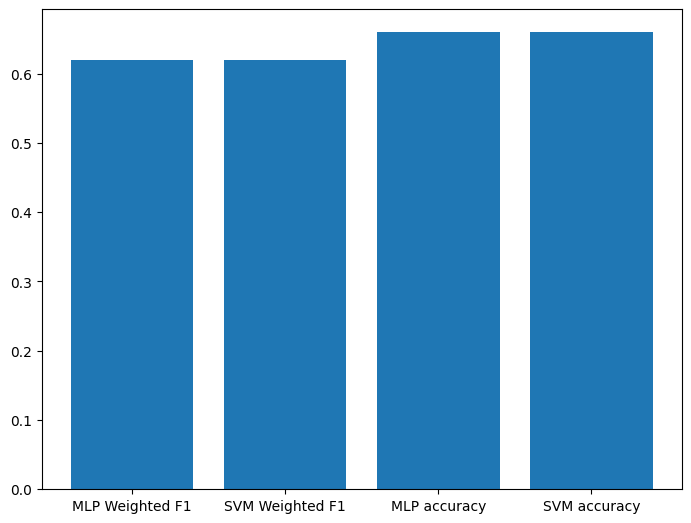

In [12]:
metrics_bar_plots(mlp_val_ootb, svc_val_ootb)

Παρατηρούμε πως η επίδοση και των δύο ταξινομητών είναι παρόμοια σε όλες τις μετρικές, και όχι ιδιαίτερα καλή. Όπως εξηγήσαμε πιο πριν, αυτό είναι αναμενόμενο από την στιγμή που χρησιμοποιούμε τους ταξινομητές μας out-of-the-box. Ακόμη, η επίδοση του SVM είναι λίγο καλύτερη τις περισσότερες φορές που τα τρέχουμε, το οποίο είναι αναμενόμενο, καθώς ο ταξινομητής SVM γενικά δουλεύει καλύτερα από τον MLP.

<font size = '6' color = 'orange'> <div align = "center"> <strong> Βελτιστοποίηση </strong> </div> </font>

# **Προεπεξεργασία**
Αρχικά θα εφαρμόσουμε την τεχνική της προεπεξεργασίας.  Το πρώτο βήμα είναι να εξασφαλίσουμε πως δεν απουσιάζουν δεδομένα, και πράγματι οπως έχουμε δει αυτό ήδη ισχύει (βλέπουμε πως δεν υπάρχουν NaN τιμές για καποιο από τα χαρακτηριστικά των δεδομένων μαςστο αντίστοιχο print). Το επόμενό μας βήμα θα είναι η μείωση της διαστατικότητας. 
Για αυτόν τον σκοπό, θα χρησιμοποιήσουμε το ελάχιστο κατώφλι της διακύμανσης (Variance Threshold). Ως ελάχιστη διακύμανση θα χρησιμοποίησουμε το 0.25 αντί για το 0, έτσι ώστε να φιλτράρουμε και χαρακτηριστικά που ναι μεν μπορεί να έχουν κάποια διακύμανση, αλλα είναι πολύ μικρή. 

In [13]:
selector = VarianceThreshold(threshold=0.25)
train_reduced = selector.fit_transform(x_train)
mask = selector.get_support()
test_reduced = x_test.loc[:,mask]

print(train_reduced.shape)
print(test_reduced.shape)

(70000, 15)
(30000, 15)


Πλέον, το test και το train set μας έχουν μόνο 15 χαρακτηριστικά, αντί για 17. 

Το επόμενο βήμα μας θα είναι η κανονικοποίηση των χαρακτηριστικων. Εδώ πρέπει να επιλέξουμε μεταξύ της μετατροπής σε standard score και της μετατροπής μεγίστου ελαχίστου. Θα χρησιμοποιησουμε μετατροπή σε standard score, καθώς γνωρίζουμε από την θεωρία ότι είναι καλύτερο για τους ταξινομητές 


In [14]:
scaler = preprocessing.StandardScaler().fit(train_reduced)
train_scaled = scaler.transform(train_reduced)
test_scaled = scaler.transform(test_reduced)

Το επόμενό μας βήμα στην διαδικασια του preprocessing, θα είναι η εξισορρόπιση του dataset, αφού όπως έχουμε ήδη δει, είναι μη ισορροπημένο. Γι αυτόν τον σκοπό, θα χρησιμοποίησουμε την τεχνική του oversampling, αφού η αυτή ενδύκνειται έτσι ώστε να μην χάσουμε δεδομένα εκπαίδευσης. 


In [15]:
ros = RandomOverSampler()
train_resampled, trainTargets_resampled = ros.fit_resample(train_scaled, final_y_train)

#checking that it worked
print(train_resampled.shape)

(108051, 15)


Θα δοκιμάσουμε επίσης να μειώσουμε και άλλο την διαστατικότητα του dataset, αναλύοντάς το σε κύριες συνιστώσες.

In [16]:
pca = PCA(n_components=8)
trainPCA = pca.fit_transform(train_resampled)
testPCA = pca.transform(test_scaled)

print(train_resampled.shape)
print(trainPCA.shape)
print("")
print(test_scaled.shape)
print(testPCA.shape)

(108051, 15)
(108051, 8)

(30000, 15)
(30000, 8)


Μειώσαμε τις διαστάσεις από 15 σε 8.

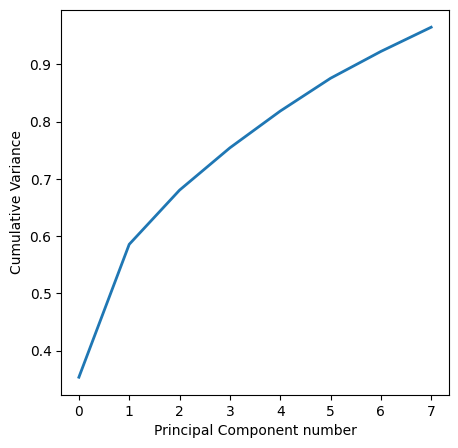

In [17]:
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

Ξανατρέχουμε τους ταξινομητές μας για να ελέγξουμε την βελτίωση που επιτύχαμε. 

**Παρατήρηση:** Και για τους δύο ταξινομητές, η ανάλυση σε κύριες συνιστώσες επέφερε χαμηλότερες επιδόσεις συγκριτικά με όταν δεν την χρησιμοποιούσαμε (και για τις δύο μετρικές), οπότε αποφασίσαμε να την αφαιρέσουμε από το κομμάτι της προεπεξεργασίας και άρα και του pipelining. 

## **MLP**

In [18]:
clf_pripro = MLPClassifier()

start = time.time()
clf_pripro.fit(train_resampled, trainTargets_resampled)
end = time.time()

mlp_pripro_time = end - start

clf_preds_pripro = clf_pripro.predict(test_scaled)
cr_mlp_pripro = classification_report(final_y_test, clf_preds_pripro)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_mlp_pripro)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, clf_preds_pripro))
print('Fit time: ', mlp_pripro_time)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.96      0.96      0.96     11526
           2       0.98      0.96      0.97     15306
           3       0.86      0.95      0.90      3168

    accuracy                           0.96     30000
   macro avg       0.93      0.96      0.94     30000
weighted avg       0.96      0.96      0.96     30000

Confusion Matrix: 
 [[11050   231   245]
 [  362 14707   237]
 [   60    98  3010]]
Fit time:  223.13275456428528


Πράγματι, η επίδοση του MLP έχει βελτιωθεί δραματικά. Πλέον όλες οι μετρικές μας φτάνουν τιμές το 96% (το weighted average για το F1).  

## **SVM**

In [19]:
svc_pripro = svm.SVC()

start = time.time()
svc_pripro.fit(train_resampled, trainTargets_resampled)
end = time.time()

svc_pripro_time = end - start

svc_preds_pripro = svc_pripro.predict(test_scaled)
cr_svc_pripro = classification_report(final_y_test, svc_preds_pripro)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_svc_pripro)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, svc_preds_pripro))
print('Fit time: ', svc_pripro_time)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.94      0.95      0.95     11526
           2       0.97      0.95      0.96     15306
           3       0.87      0.93      0.90      3168

    accuracy                           0.95     30000
   macro avg       0.93      0.94      0.94     30000
weighted avg       0.95      0.95      0.95     30000

Confusion Matrix: 
 [[10912   345   269]
 [  563 14579   164]
 [   87   121  2960]]
Fit time:  230.30513644218445


Όμοια με τον MLP, η επιδόση του SVM ταξινομητή αυξάνεται σημαντικα, πετυχαίνοντας σχεδόν το ίδιο σκορ με αυτόν.

Τέλος, θα δοκιμάσουμε ακόμη μια πρακτική για μείωση της διαστατικότητας: θα μελετήσουμε τα attributes του dataset, και θα αφαιρέσουμε αυτά τα οποία δεν είναι σχετικά με την ταξινόμηση. 

Βρίσκουμε πως  τα χαρακτηριστικά 'run', 'rerun', 'camcol', 'field', 'plate', 'mjd', 'objid', 'specobjid' και 'fiberid' μπορούν να αφαιρεθούν από το dataframe, καθώς τα 6 πρώτα αφορούν ποσοτικά δεδομένα σχετικά με το τηλεσκόπιο που συνέλαβε τα δεδομένα καθώς και πληροφορίες για την ίδια την λήψη (επομένως δεν επηρεάζουν την κατηγορία στην οποία ανήκει ένα αντικείμενο), ενώ τα υπόλοιπα πεδία απλά λειτουργούν ως βοηθητικοί identifiers για τα δεδομένα στο αρχικό databank. Τέλος, τα πεδία 'ra' και 'dec' περιέχουν συντεταγμένες του αντικειμένου στο διάστημα, που σημαίνει ότι μπορούν να πραλειφθούν καθώς δεν συμβάλλουν στο classification του αντικειμένου. 

Θα αφαιρέσουμε λοιπόν αυτά τα χαρακτηριστικά από το dataset, και θα επαναλάβουμε την διαδικασία από την αρχή. 

**Σημείωση:** Αυτήν την φορά αφαιρέσαμε το variance threshold γιατί παρατηρήσαμε ότι μας έριχνε την επίδοση. Δεν παραθέτουμε όλες τις δοκιμές μας για εξοικονόμιση χώρου, καθώς η εργασία έχει πολύ μεγάλη έκταση. Ακόμη, αν και χρησιμοποιούμε διαφορετικό train-test set στις δύο δοκιμές προεπεξεργασίας, τρεχοντας τα συγκεκριμένα κελιά πολλές φορές παρατηρήσαμε ότι δεν άλλαζαν οι επιδόσεις που λαμβάναμε, γεγονός που μας επιτρέπει να συγκρίνουμε τις μετρήσεις των δύο αυτών σχημάτων προεπεξεργασίας.

In [20]:
#dropping the attributes
y_pripro = df['class']
x_pripro = df.drop(['run', 'rerun', 'camcol', 'field', 'class', 'objid', 'specobjid', 'fiberid', 'plate', 'mjd', 'ra', 'dec'], axis = 1)

#splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(x_pripro, y_pripro, test_size=0.30)

#converting categorical labels into numerical
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
final_y_train = []
final_y_test = []
for cl in y_train:
    final_y_train.append(labels[cl])
for cl in y_test:
    final_y_test.append(labels[cl])

#variance threshold
#selector = VarianceThreshold(threshold=0.25)
#train_reduced = selector.fit_transform(x_train)
#mask = selector.get_support()
#test_reduced = x_test.loc[:,mask]

#standard scaler
scaler = preprocessing.StandardScaler().fit(x_train)
train_scaled = scaler.transform(x_train)
test_scaled = scaler.transform(x_test)

#balancing dataset
ros = RandomOverSampler()
train_resampled, trainTargets_resampled = ros.fit_resample(train_scaled, final_y_train)

Τέχουμε πάλι τους ταξινομητές μας. 

## **MLP**

In [21]:
clf_pripro_2 = MLPClassifier()

start = time.time()
clf_pripro_2.fit(train_resampled, trainTargets_resampled)
end = time.time()

mlp_pripro_time_2 = end - start

clf_preds_pripro_2 = clf_pripro_2.predict(test_scaled)
cr_mlp_pripro_2 = classification_report(final_y_test, clf_preds_pripro_2)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_mlp_pripro_2)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, clf_preds_pripro_2))
print('Fit time: ', mlp_pripro_time_2)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.99      1.00      0.99     11485
           2       0.99      0.98      0.99     15347
           3       0.95      0.97      0.96      3168

    accuracy                           0.99     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[11478     6     1]
 [  165 15025   157]
 [    2    79  3087]]
Fit time:  35.11260223388672


## **SVM**

In [22]:
svc_pripro_2 = svm.SVC()

start = time.time()
svc_pripro_2.fit(train_resampled, trainTargets_resampled)
end = time.time()

svc_pripro_time_2 = end - start

svc_preds_pripro_2 = svc_pripro_2.predict(test_scaled)
cr_svc_pripro_2 = classification_report(final_y_test, svc_preds_pripro_2)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_svc_pripro_2)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, svc_preds_pripro_2))
print('Fit time: ', svc_pripro_time_2)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.97      1.00      0.98     11485
           2       0.99      0.97      0.98     15347
           3       0.97      0.96      0.97      3168

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000

Confusion Matrix: 
 [[11456    27     2]
 [  385 14885    77]
 [    5   117  3046]]
Fit time:  39.994905948638916


Παρατηρούμε πως και για τους δύο ταξινομητές η επίδοση έχει βελτιωθεί ακόμη περισσότερο. Επομένως θα κρατήσουμε την αφαίρεση αυτών των attributes ως μέρος της προεπεγεργασίας μας. 

Ακολουθούν ένας πίνακας Markdown τα διγράμματα bar plot των αποτελεσμάτων μας.

|  | MLP | SVM |
| --- | ---- | ---- |
|Accuracy |  0.99  | 0.98  |
| F1  |   0.99 | 0.98   |

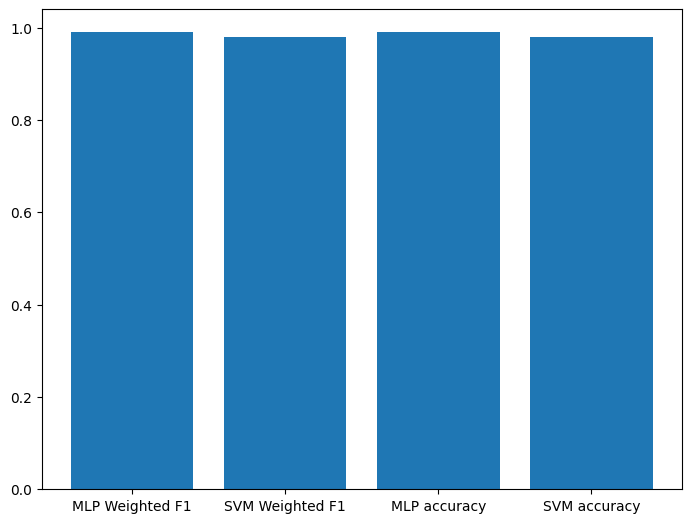

In [23]:
mlp_val_pripro_2 = get_weighted_avg_acc(cr_mlp_pripro_2)
svc_val_pripro_2 = get_weighted_avg_acc(cr_svc_pripro_2)
metrics_bar_plots(mlp_val_pripro_2, svc_val_pripro_2)

Όπως βλέπουμε, η δεύτερη προσέγγιση της προεπεξεργασίας επέφερε και για τους δύο ταξινομητές (κατα πολύ λίγο) καλύτερα αποτελέσματα από την πρώτη. Αυτό συμβαίνει διότι μελετώντας το dataset διεξοδικά μπορούμε με μεγαλύτερη ακρίβεια και ορθότητα να μειώσουμε την διαστατικότητα του dataset, διαγράφωντας χαρακτηριστικά που όντως δεν προσφέρουν σχετικές ως προς την ταξινόμηση πληροφοριές και κρατώντας τα απαραίτητα μόνο, κάτι που δεν μπορεί να κάνει με τέτοια ακρίβεια oι συναρτήσεις του sklearn. Συνεπώς, θα κρατήσουμε το δεύτερο σχήμα προεπεξεργασίας.

# **Pipelining**

Θα ενώσουμε τώρα όλες τις προαναφερθήσες λειτουργίες preprocessing σε δύο μοντέλα εκτιμητών, ένα που χρησιμοποιεί τον MLP ως εκτιμητή και ένα τον SVM.

## **MLP**

In [24]:
clf_pipe = MLPClassifier()
#The line below is what our pipeline would look like if we had used all the preprocessing techniques that we tried
#clf_pipeline = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('sampler', ros), ('clf', clf_pipe)], memory = 'tmp')
clf_pipeline = Pipeline(steps=[('scaler', scaler), ('sampler', ros), ('clf', clf_pipe)], memory = 'tmp')

start = time.time()
clf_pipeline.fit(x_train, final_y_train)
end = time.time()

mlp_pipe_time = end - start

clf_preds_pipe = clf_pipeline.predict(x_test)
cr_mlp_pipe = classification_report(final_y_test, clf_preds_pipe)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_mlp_pipe)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, clf_preds_pipe))
print('Fit time: ', mlp_pipe_time)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.99      1.00      0.99     11485
           2       0.99      0.98      0.99     15347
           3       0.96      0.97      0.97      3168

    accuracy                           0.99     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[11464    19     2]
 [  157 15076   114]
 [    2    86  3080]]
Fit time:  56.250449657440186


## **SVM**

In [25]:
svc_pipe = svm.SVC()
svc_pipeline = Pipeline(steps=[('scaler', scaler), ('sampler', ros), ('svc', svc_pipe)], memory = 'tmp')

start = time.time()
svc_pipeline.fit(x_train, final_y_train)
end = time.time()

svc_pipe_time = end - start

svc_preds_pipe = svc_pipeline.predict(x_test)
cr_svc_pipe = classification_report(final_y_test, svc_preds_pipe)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_svc_pipe)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, svc_preds_pipe))
print('Fit time: ', svc_pipe_time)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.97      1.00      0.98     11485
           2       0.99      0.97      0.98     15347
           3       0.98      0.96      0.97      3168

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000

Confusion Matrix: 
 [[11458    25     2]
 [  384 14887    76]
 [    5   119  3044]]
Fit time:  39.57871770858765


Παρακάτω βλέπουμε τις επιδόσεις των εκτιμητών με βάση τις μετρικές μας.

|  | MLP | SVM |
| --- | ---- | ---- |
|Accuracy |  0.99  | 0.98  |
| F1  |   0.99 | 0.98   |

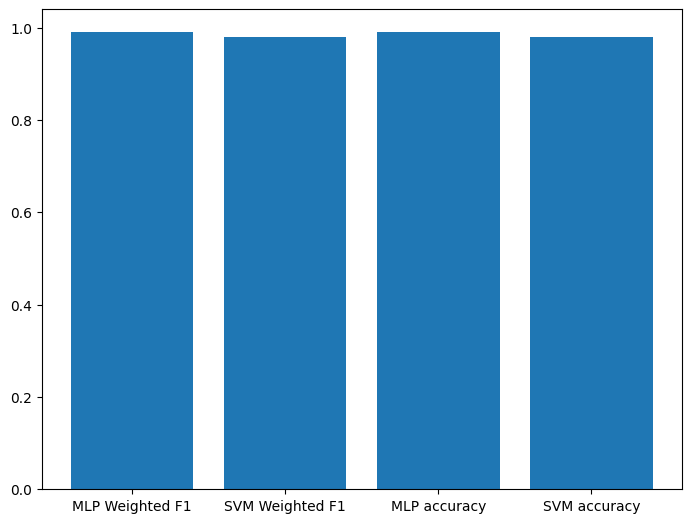

In [26]:
mlp_val_pipe = get_weighted_avg_acc(cr_mlp_pipe)
svc_val_pipe = get_weighted_avg_acc(cr_svc_pipe)
metrics_bar_plots(mlp_val_pipe, svc_val_pipe)

Παρατηρούμε πως η επίδοση σε αυτήν την περίπτωση είναι πρακτικά η ίδια σε σύγκριση με τα αποτελέσματα της τεχνικής της Προεπεξεργασίας που εκτελέσαμε βήμα βήμα μόνοι μας. Αυτό είναι αναμενόμενο, καθώς χρησιμοποίησαμε ακριβώς τις ίδιες τεχνικές. Αυτό όμως που βελτιώθηκε ήταν ο χρόνος εκτέλεσης, το οποίο ήταν και αυτό αναμενόμενο. 

# **Eύρεση βέλτιστων υπερπαραμέτρων με αναζήτηση πλέγματος με διασταυρούμενη επικύρωση**
Παρακάτω θα αναζητήσουμε τις βέλτιστες υπερπαραμέτρους για τους ταξινομητές μας χρησιμοποιώντας την μέθοδο αναζήτησης πλέγματος με διασταυρούμενη επικύρωση. Πιο συγκεκριμένα, θα χρησιμοποιήσουμε την συνάρτηση βελτιστοποίησης Ray για tune grid search με cross validation, καθώς είναι αρκετά γρηγορότερη και παράλληλα καταναλώνει αρκετά λιγότερους πόρους μνήμης σε σχέση με άλλες μεθόδους βελτιστοπίησης, κάτι που θα φανεί πολύ χρήσιμο στην περίπτωσή μας που έχουμε μεγάλο dataset Τέλος, επιλέξαμε το cross validation να είναι 5-fold, έτσι ώστε να μην πάρει υπερβολικά πολύ ώρα αφού εχουμε μεγάλο dataset και εξετάζουμε αρκετές παραμέτρους.

## **MLP**

Για την διασταυρούμενη επικύρωση αποφασίσαμε να χρησιμοποιήσουμε το Accuracy ως την μετρική στο scoring του TuneGridSearchCV, αφού το dataset μας δεν είναι πια μη-ισορροπημένο. 

Δοκιμάσαμε επίσης να χρησιμοποιήσουμε τις παραμέτρους warm_start και early_stopping στο param_grid, έτσι ώστε να επιταχύνουμε την διαδικασία αλλά τελικά τις αφαιρέσαμε καθώς φάνηκε πως χειροτέρευαν την επίδοση του MLP. 

Ακόμη, το max_iter τέθηκε στο 400 (αντί για το default 200), έτσι ώστε να συγκλίνουν περισσότερες επαναλήψεις, αφού αρκετές δεν συνέκλειναν. Εξακολουθούν να υπάρχουν κάποιες που δεν συγκλίνουν, αυτό όμως είναι αναμενόμενο. 


In [27]:
parameter_space = {
    'clf__hidden_layer_sizes': [(100,),(200,)],#trying the default and double that
    'clf__activation': ['identity', 'logistic', 'tanh', 'relu'], #all activation functions
    'clf__solver': ['sgd', 'adam'], #all solvers but lbfgs because we have a large dataset
    'clf__alpha': [0.0001, 0.05], #trying for default and a larger alpha
    'clf__learning_rate': ['constant','adaptive'], #all learning rates but invscaling
    'clf__max_iter': [400], #We increase the max_iter parameter to 400 so that more optimizations will converge
    #'clf__warm_start': ['True'], #We use this to decrease the running time and achieve better results
    #'clf__early_stopping': [True], #We use this to decrease the running time 
}

scorer = make_scorer(accuracy_score)
tune_grid_search_mlp = TuneGridSearchCV(clf_pipeline, 
                                    param_grid = parameter_space, 
                                    scoring=scorer, 
                                    n_jobs=-1, 
                                    cv=5, 
                                    verbose=3) #reduce this if too many useless reults

start = time.time()
# Fit grid search
grid_result_mlp = tune_grid_search_mlp.fit(x_train, final_y_train)
end = time.time()
print("Tune Grid Search Time:", end - start)
# Print grid search summary
grid_result_mlp

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result_mlp.best_score_:.2f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result_mlp.best_params_}')

2022-11-30 00:26:22,951	INFO worker.py:1528 -- Started a local Ray instance.


(<ray.tune.trainable.util._Trainable object at 0x7f32e1850580> pid=299639) /home/theo/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
(<ray.tune.trainable.util._Trainable object at 0x7f32e1850580> pid=299639)   warnings.warn(


Trial name,average_test_score,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,objective,pid,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
_Trainable_db579_00000,0.979586,2022-11-30_00-32-45,True,,0a3aac36925d43fb89148133585eda43,unity,1,10.0.2.15,0.979586,299605,0.980071,0.9775,0.981429,0.978571,0.980357,379.473,379.473,379.473,1669761165,0,,1,db579_00000,0.0723844
_Trainable_db579_00001,0.970329,2022-11-30_00-42-41,True,,69a696a22ea34a8e961ce35ca109fb94,unity,1,10.0.2.15,0.970329,299639,0.971714,0.966929,0.971357,0.967714,0.973929,972.565,972.565,972.565,1669761761,0,,1,db579_00001,0.105724
_Trainable_db579_00002,0.979929,2022-11-30_00-40-58,True,,5267517eaad74ad7be493d1d4e271f19,unity,1,10.0.2.15,0.979929,299641,0.9815,0.978143,0.980929,0.979214,0.979857,869.506,869.506,869.506,1669761658,0,,1,db579_00002,0.142537
_Trainable_db579_00003,0.981286,2022-11-30_00-36-16,True,,1cbde200a4b6472082ced98267868d68,unity,1,10.0.2.15,0.981286,299642,0.982071,0.979071,0.982929,0.980714,0.981643,588.031,588.031,588.031,1669761376,0,,1,db579_00003,0.12147
_Trainable_db579_00004,0.976486,2022-11-30_00-30-56,True,,ab02563b75a445a289a3cae44c3a89fc,unity,1,10.0.2.15,0.976486,299647,0.977,0.974,0.978786,0.9745,0.978143,267.686,267.686,267.686,1669761056,0,,1,db579_00004,0.103015
_Trainable_db579_00005,0.962514,2022-11-30_00-40-54,True,,8cce95a51066436c86da6c4391784823,unity,1,10.0.2.15,0.962514,299650,0.964214,0.9595,0.9625,0.960929,0.965429,865.972,865.972,865.972,1669761654,0,,1,db579_00005,0.119751
_Trainable_db579_00006,0.976486,2022-11-30_00-42-35,True,,ab02563b75a445a289a3cae44c3a89fc,unity,1,10.0.2.15,0.976486,299647,0.977857,0.973929,0.977143,0.9755,0.978,698.449,698.449,698.449,1669761755,0,,1,db579_00006,0.103015
_Trainable_db579_00007,0.9777,2022-11-30_00-41-28,True,,0a3aac36925d43fb89148133585eda43,unity,1,10.0.2.15,0.9777,299605,0.978857,0.975286,0.978786,0.976786,0.978786,523.141,523.141,523.141,1669761688,0,,1,db579_00007,0.0723844
_Trainable_db579_00008,0.979457,2022-11-30_00-45-44,True,,1cbde200a4b6472082ced98267868d68,unity,1,10.0.2.15,0.979457,299642,0.980786,0.9775,0.980286,0.978,0.980714,567.598,567.598,567.598,1669761944,0,,1,db579_00008,0.12147
_Trainable_db579_00009,0.971,2022-11-30_01-09-45,True,,8cce95a51066436c86da6c4391784823,unity,1,10.0.2.15,0.971,299650,0.972357,0.968143,0.972214,0.968714,0.973571,1730.95,1730.95,1730.95,1669763385,0,,1,db579_00009,0.119751


2022-11-30 00:30:56,714	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'clf__hidden_layer_sizes': (100,)}
(<ray.tune.trainable.util._Trainable object at 0x7f32e1850580> pid=299639) /home/theo/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
(<ray.tune.trainable.util._Trainable object at 0x7f32e1850580> pid=299639)   warnings.warn(
2022-11-30 00:32:45,482	INFO tensorboardx.py:267 -- Removed the following hyperparameter values when logging to tensorboard: {'clf__hidden_layer_sizes': (100,)}
(<ray.tune.trainable.util._Trainable object at 0x7f32e1850580> pid=299639) /home/theo/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.


Tune Grid Search Time: 8478.382166147232
The best accuracy score for the training dataset is 0.99
The best hyperparameters are {'clf__hidden_layer_sizes': (100,), 'clf__activation': 'tanh', 'clf__solver': 'adam', 'clf__alpha': 0.0001, 'clf__learning_rate': 'adaptive', 'clf__max_iter': 400}


## **SVM**

Θα επαναλάβουμε την ίδια διαδικασία και για το SVM, εξετάζοντας καιγια διάφορες τιμές των υπερπαραμέτρων C και Gamma, για τους δύο πυρήνες rbf και linear. Δοκιμάσαμε και τους πυρήνες poly και sigmoid αλλά καθυστερούσαν πάρα πολύ την διαδικάσία (πάνω από 20 ώρες) και δεν είχαν ιδιαίτερα αποτελέσματα, οπότε επιλέξαμε να τα αφαιρέσουμε από το parameter grid.

In [35]:
# Define the search space
param_grid = { 
    # Regularization parameter.
    'svc__C': [0.1, 1, 10, 100, 1000],
    # Kernel type
    'svc__kernel': ['rbf', 'linear'],
    # Gamma is the Kernel coefficient for ‘rbf’
    'svc__gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
    }

tune_grid_search_svc = TuneGridSearchCV(svc_pipeline, 
                                    param_grid=param_grid, 
                                    scoring=scorer, 
                                    n_jobs=-1, 
                                    cv=5, 
                                    verbose=3)

start = time.time()
# Fit grid search
grid_result_svc = tune_grid_search_svc.fit(x_train, final_y_train)
end = time.time()
print("Tune Grid Search Time:", end - start)
# Print grid search summary
grid_result_svc

# Print the best f1 score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result_svc.best_score_:.2f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result_svc.best_params_}')

Trial name,average_test_score,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,objective,pid,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
_Trainable_06db0_00000,0.959786,2022-11-30_06-27-16,True,,6f2748bf6031416bb850a589fe91c72a,unity,1,10.0.2.15,0.959786,342176,0.960143,0.954929,0.963,0.958071,0.962786,960.163,960.163,960.163,1669782436,0,,1,06db0_00000,0.0770619
_Trainable_06db0_00001,0.978971,2022-11-30_06-32-40,True,,48e37fb0b3c14d62bf29c9a7146948fd,unity,1,10.0.2.15,0.978971,342308,0.980286,0.9755,0.980786,0.979,0.979286,1280.04,1280.04,1280.04,1669782760,0,,1,06db0_00001,0.230408
_Trainable_06db0_00002,0.980143,2022-11-30_06-35-43,True,,ec19e4673b024926b664cea79cf0b1d2,unity,1,10.0.2.15,0.980143,342311,0.980357,0.977143,0.981,0.980786,0.981429,1463.86,1463.86,1463.86,1669782943,0,,1,06db0_00002,0.25052
_Trainable_06db0_00003,0.977457,2022-11-30_06-37-59,True,,cf7b47094cc943e2839ef2b7f44a9e94,unity,1,10.0.2.15,0.977457,342312,0.976929,0.975929,0.979,0.977857,0.977571,1599.44,1599.44,1599.44,1669783079,0,,1,06db0_00003,0.107025
_Trainable_06db0_00004,0.9738,2022-11-30_06-44-31,True,,1d2a51f1e63749af8483d08022698141,unity,1,10.0.2.15,0.9738,342317,0.972857,0.971214,0.9755,0.975,0.974429,1992.26,1992.26,1992.26,1669783471,0,,1,06db0_00004,0.119648
_Trainable_06db0_00005,0.965343,2022-11-30_06-19-31,True,,48302b2086544f5e9db751c1bb1cbc4e,unity,1,10.0.2.15,0.965343,342320,0.966643,0.962714,0.966214,0.963857,0.967286,491.758,491.758,491.758,1669781971,0,,1,06db0_00005,0.155289
_Trainable_06db0_00006,0.980143,2022-11-30_06-24-20,True,,48302b2086544f5e9db751c1bb1cbc4e,unity,1,10.0.2.15,0.980143,342320,0.980857,0.977143,0.982214,0.979143,0.981357,288.69,288.69,288.69,1669782260,0,,1,06db0_00006,0.155289
_Trainable_06db0_00007,0.983929,2022-11-30_06-28-18,True,,48302b2086544f5e9db751c1bb1cbc4e,unity,1,10.0.2.15,0.983929,342320,0.983071,0.981,0.985857,0.984571,0.985143,238.519,238.519,238.519,1669782498,0,,1,06db0_00007,0.155289
_Trainable_06db0_00008,0.985214,2022-11-30_06-33-12,True,,6f2748bf6031416bb850a589fe91c72a,unity,1,10.0.2.15,0.985214,342176,0.984357,0.983286,0.9865,0.985286,0.986643,356.366,356.366,356.366,1669782792,0,,1,06db0_00008,0.0770619
_Trainable_06db0_00009,0.984143,2022-11-30_06-42-54,True,,48302b2086544f5e9db751c1bb1cbc4e,unity,1,10.0.2.15,0.984143,342320,0.983357,0.982571,0.984857,0.984143,0.985786,875.388,875.388,875.388,1669783374,0,,1,06db0_00009,0.155289


2022-11-30 11:06:34,606	INFO tune.py:777 -- Total run time: 17721.87 seconds (17721.73 seconds for the tuning loop).


Tune Grid Search Time: 17772.43841934204
The best accuracy score for the training dataset is 0.99
The best hyperparameters are {'svc__C': 1000, 'svc__kernel': 'rbf', 'svc__gamma': 0.1}


Τρέχουμε μια τελευταία φορα τους ταξινομητές μας, αυτήν την φορά με τις βέλτιστες υπερπαραμέτρους (εκτός από αυτές που βγήκαν ίδιες με το default οπότε δεν χρειάζεται να τις ορίσουμε καθόλου).

## **MLP**

In [33]:
clf_final = MLPClassifier(activation = 'tanh', learning_rate = 'adaptive', max_iter = 400)
clf_pipeline_final  = Pipeline(steps=[('scaler', scaler), ('sampler', ros), ('clf', clf_final)], memory = 'tmp')

start = time.time()
clf_pipeline_final.fit(x_train, final_y_train)
end = time.time()

mlp_final_time = end - start

clf_preds_final = clf_pipeline_final.predict(x_test)
cr_mlp_final = classification_report(final_y_test, clf_preds_final)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_mlp_final)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, clf_preds_final))
print('Fit time: ', mlp_final_time)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.99      1.00      0.99     11485
           2       0.99      0.98      0.99     15347
           3       0.96      0.97      0.97      3168

    accuracy                           0.99     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[11480     5     0]
 [  167 15042   138]
 [    2    82  3084]]
Fit time:  94.02272248268127


Παρατηρούμε πως το gridsearch μας δείχνει πως οι περισσότερες βέλτιστες υπερπαράμετροι είναι οι default. Επιπλέον ακόμη και με όλες τις βέλτιστες υπερπαραμέτρους, η επίδοση του MLP βελτιώνεται ελάχιστα έως και καθόλου (σε διαφορετικές επαναλήψεις). Συμπεραίνουμε λοιπόν πως η βελτιστοποίηση των υπερπαραμέτρων δεν είναι αναγκαίο βήμα για τον ταξινομητή MLP για το συγκεκριμένο dataset. 

## **SVM**

In [38]:
svc_final = svm.SVC(gamma = 0.1, C = 1000, kernel = 'rbf') # default: { kernel: 'rbf', gamma: 'scaled', C: 1.0}
svc_pipeline_final = Pipeline(steps=[('scaler', scaler), ('sampler', ros), ('svc', svc_final)], memory = 'tmp')

start = time.time()
svc_pipeline_final.fit(x_train, final_y_train)
end = time.time()

svc_final_time = end - start

svc_preds_final = svc_pipeline_final.predict(x_test)
cr_svc_final = classification_report(final_y_test, svc_preds_final)

print('Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: \n', cr_svc_final)
print('Confusion Matrix: \n', confusion_matrix(final_y_test, svc_preds_final))
print('Fit time: ', svc_final_time)

Scores per class [STAR = 1, GALAXY = 2, QSO = 3]: 
               precision    recall  f1-score   support

           1       0.99      1.00      0.99     11485
           2       0.99      0.98      0.99     15347
           3       0.97      0.96      0.97      3168

    accuracy                           0.99     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.99      0.99      0.99     30000

Confusion Matrix: 
 [[11471    14     0]
 [  155 15103    89]
 [    9   109  3050]]
Fit time:  61.22372603416443


Τέλος, παρουσιάζουμε έναν πίνακα Markdown και τα διαγράμματα bar plot με τις αντίστοιχες μετρήσεις.

|  | MLP | SVM |
| --- | ---- | ---- |
|Accuracy |  0.99  | 0.99  |
| F1  |   0.99 | 0.99   |

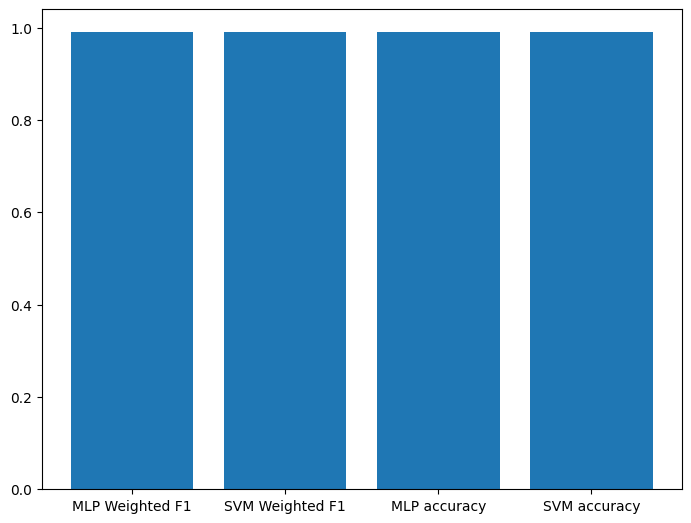

In [39]:
mlp_val_final = get_weighted_avg_acc(cr_mlp_final)
svc_val_final = get_weighted_avg_acc(cr_svc_final)
metrics_bar_plots(mlp_val_final, svc_val_final)

# **Συγκριτική επισκόπιση των MLP και SVM**

### **MLP**

Ο ταξινομητής MLP δεν λειτουργεί πολύ καλά, όταν χρησιμοποιείται out of the box. Με την σωστή όμως προεπεξεργασία των δεδομένων (μια εύκολη και γρήγορη διαδικασία που μπορεί να γίνει ακόμη γρηγορότερη με χρήση pipelines), επιτυγχάνουμε πολύ μεγάλα accuracy και F1, δηλαδή ο ταξινομητής λειτουργεί πολύ καλά. Ταυτόχρονα, τελειώνει την ταξινόμηση σχετικά γρήγορα, το οποίο μας βοηθά στην εξοικονόμιση χρόνου. 

### **SVM**

Όμοια με τον MLP, ο SVM παρουσιάζει χαμηλή επίδοση στην out of the box εκτέλεση, ενώ ύστερα από την προεπεξεργασία μέσω pipelining και το tuning των υπερπαραμέτρων του, βελτιώνεται σημαντικά, τόσο η επίδοσή του όσο και ο χρόνος του.

### **Συνολικά**

Τελικά, και τα δύο μοντέλα μας καταλήγουν να έχουν την ίδια επίδοση και στις δύο μετρικές μας, επομένως μπορεί να χρησιμοποιηθεί οποιδήποτα από τα δύο. Εμείς προτείνουμε το SVM γιατί έχει λίγο μικρότερο χρόνο εκτέλεσης συγκριτικά με το MLP. 